In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    ! [ ! -d mn_k12_cases ] && git clone https://github.com/eborisch/mn_k12_cases.git
    ! cd mn_k12_cases && ./scrape_current.py && ./update_min_max.py

    from google.colab import output

    DDIR='mn_k12_cases'

    # If I ever get around to creating an interface.
    #!pip install matplotlib numpy #ipywidgets ipympl
    #%matplotlib widget
    #import ipywidgets as widg
else:
    ! ./scrape_current.py && ./update_min_max.py
    DDIR='.'

Can't find ['0085-01-004', 'Brown', 'Springfield Public Schools ESY', 'Springfield', '0-4', '5-9', '0-4', '0-4']
Can't find ['4199-07-030', 'Hennepin', 'Parnassus Preparatory School', 'Maple Grove', '20-29', '5-9', '0-4', '0-4']
Can't find ['0085-01-004', 'Brown', 'Springfield Public Schools ESY', 'Springfield', '5-9', '0-4', '0-4', '0-4']
Can't find ['4199-07-030', 'Hennepin', 'Parnassus Preparatory School ESY', 'Maple Grove', '10-19', '0-4', '0-4', '0-4']
Can't find ['0085-01-004', 'Brown', 'Springfield Public Schools ESY', 'Springfield', '0-4', '0-4', '0-4', '0-4']
Can't find ['4199-07-030', 'Hennepin', 'Parnassus Preparatory School ESY', 'Maple Grove', '5-9', '0-4', '0-4', '0-4']
Can't find ['0279-01-698', 'Hennepin', 'Arbor View Ech. Special Ed.', 'Maple Grove', '0-4', '5-9', '0-4', '0-4']
Can't find ['4199-07-030', 'Hennepin', 'Parnassus Preparatory School', 'Maple Grove', '0-4', '5-9', '5-9', '0-4']
Can't find ['4015-07-013', 'Ramsey', 'Community of Peace Academy', 'Saint Paul',

In [4]:
import collections
import colorsys
import csv
import datetime
import re

import os.path

from datetime import datetime as dt

import matplotlib

import matplotlib.pyplot as pp
import numpy as np

path = lambda x:os.path.join(DDIR, x)

pp.rcParams["figure.figsize"] = (10,10)
date2num = matplotlib.dates.date2num
dd = collections.defaultdict

In [5]:
MINS = []
MAXS = []
META_N = 6
META = []
POPS = []
GRADES = []

with open(path('maximums.csv')) as maxfile:   
    with open(path('minimums.csv')) as minfile:
        mincsv = csv.reader(minfile)
        maxcsv = csv.reader(maxfile)

        header = next(mincsv)
        next(maxcsv)

        META_COLS = header[:META_N]
        DATES = [dt.strptime(x, '%Y/%m/%d') for x in header[META_N:]]
        pop_idx = META_COLS.index('Enrollment')
        for row in mincsv:
            META.append(row[:META_N])
            # I don't have staff numbers, but 15% of student population lines
            # up with some cases where I do have staff/student numbers
            pop = round(int(row[pop_idx]) * 1.15)
            POPS.append(pop)
            MINS.append([int(x)/pop for x in row[META_N:]])
            maxrow = next(maxcsv)
            if META[-1] != maxrow[:META_N]:
                print(META[-1])
                print(maxrow[:META_N])
                raise(Exception("DATA NOT ALIGNED!!"))
            MAXS.append([int(x)/pop for x in maxrow[META_N:]])
            GRADES.append(int(META[-1][-1]))

POPS = np.array(POPS)
DATES.insert(0, DATES[0]-datetime.timedelta(14))
MINS = 100 * np.array(MINS)
MAXS = 100 * np.array(MAXS)
MINS = np.concatenate((np.zeros((MINS.shape[0],1)),MINS),1)
MAXS = np.concatenate((np.zeros((MINS.shape[0],1)),MAXS),1)
CUMULATIVE = True
if not CUMULATIVE:
    DATES = DATES[1:-2]
    MAXS= np.diff(MAXS, axis=1)[:,:-2]
    MINS = np.diff(MINS, axis=1)[:,:-2]


In [6]:
def get_color(n):
    return matplotlib.colors.to_rgb('C{}'.format(n))

def plot_entity(label, pop, mins, maxs, cindex, color_map={}, plot_min=True,
                plot_max=True):
    if mins[-1] > 0:
        has_data = True
    else:
        has_data = False
    
    if len(color_map):
        c = color_map[cindex]
    else:
        c = get_color(cindex)
    
    label = re.sub(r'(Public )?School(s| Dist(rict|\.))','',label)
    
    opts = {
        'label':        label,
        #'linewidth':    (pop/pmax + 1) * 2,
        'linestyle':    '-' if has_data else ':',
        #'zorder':       n,
    }
    if not CUMULATIVE:
        opts.pop('linestyle')
    fill_opts = {
        'edgecolor':    (*c, 0.5 if has_data else 0.2),
        #'facecolor':    (*c, (0.5 * pop/pmax) if has_data else 0.01),
        'facecolor':    (*c, 0.1  if has_data else 0.0),
    }
    line_opts = {
        'alpha':        0.9 if has_data else 0.3,
        'color':        c
    }

    if plot_min and plot_max:
        opts.update(fill_opts)
        p = pp.fill_between(DATES, maxs[:], mins[:],
                            **opts)
        title = 'range'
        pp.plot(DATES, (maxs + mins)/2, color=c)
        text_y = (mins[-1] + maxs[-1])/2
    else:
        opts.update(line_opts)
        if plot_max:
            p = pp.plot(DATES, maxs[:], **opts)
            title = 'range max'
            text_y = maxs[-1]
        elif plot_min:
            p = pp.plot(DATES, mins[:], **opts)
            title = 'range min'
            text_y = mins[-1]
    c = colorsys.rgb_to_hsv(*c)
    c = colorsys.hsv_to_rgb(c[0], c[1], c[2]*0.5)
    h = pp.text(pp.xlim()[1] + 1,
                text_y, '{:.1f}% '.format(text_y) + label,
                ha='left', va='center', color=c,
                alpha=line_opts['alpha'])
    return p, title, h


def _unbunch(batch, dy):
    yloc = lambda x: x.get_position()[1]
    pct = lambda x: float(re.match('[0-9.]+', x.get_text())[0])
    batch = sorted(batch, key = lambda n: pct(n), reverse=True)

    n = len(batch)
    if n == 1:
        return False
    mid = np.median([yloc(x) for x in batch])
    changed = False
    for c,b in enumerate(batch):
        p = mid - (c - (n-1)/2) * dy * 0.75
        if abs(p-yloc(b)) > (dy / 40):
            b.set_y(p)
            changed = True
    return changed


def unbunch_labels(labels, slots):
    dy = pp.ylim()
    dy = (dy[1] - dy[0])/slots
    yloc = lambda x: x.get_position()[1]
    labels = sorted(labels, key = lambda n: yloc(n), reverse=True)

    batch = []
    changed = False
    for l in labels:
        yl = yloc(l)
        if len(batch) == 0 or min(abs(yl - yloc(n)) for n in batch) < dy:
            batch.append(l)
        else:
            changed = changed | _unbunch(batch, dy)
            batch = [l]
    if len(batch) > 1:
        changed = changed | _unbunch(batch, dy)
    if changed:
        unbunch_labels(labels, slots)

def annotate_plot(title):
    pp.title(title)
    pp.grid(True)
    pp.ylabel('% of population')
    pp.xlabel('Two-week period end date')
    pp.xticks(DATES)
    yl = pp.ylim()
    xy = np.array([[date2num(DATES[_]) for _ in (-1,-3,-3,-1)],
                   [yl[_] for _ in (0,0,1,1)]])
    if CUMULATIVE:
        pp.gca().add_patch(pp.Polygon(xy.T,
                closed=True, facecolor=(0,0,0,0.1), edgecolor=(0,0,0,0.5)))
        pp.text(date2num(DATES[-2]),
                pp.ylim()[0], 'Incomplete\nData Range', va='bottom', ha='center',
                weight='bold')
    pp.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    pp.tight_layout()
   

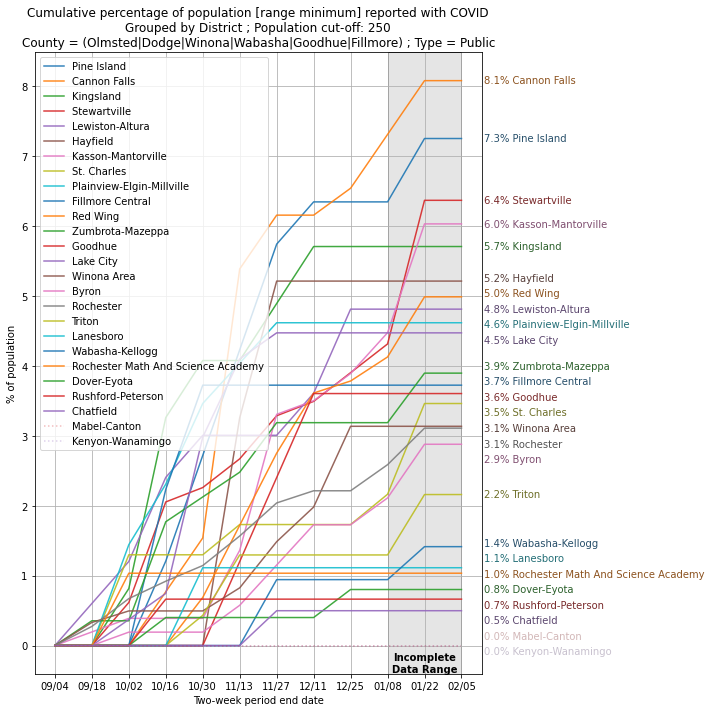

In [7]:
def select_rows(min_pop=0, has_grade=None, **kwargs):
    filters = [re.compile('.*')] * META_N

    for arg,val in kwargs.items():
        if arg not in META_COLS:
            print("Bad filter name [{}]; known filterable parameters:\n" \
                  "  {}" .format(arg, ', '.join(sorted(META_COLS))))
            raise(KeyError("Unknown filter argument."))
        filters[META_COLS.index(arg)] = re.compile(val)

    rows = []
    for n,m in enumerate(META):
        if all(x[0].search(x[1]) for x in zip(filters, m)) \
           and POPS[n] >= min_pop:
            if has_grade is None:
                rows.append(n)
            elif GRADES[n] & 2**has_grade:
                rows.append(n)

    if not rows:
        print("No schools returned with filter rules:")
        for arg,val in kwargs.items():
            print("  [{}] matching [{}]".format(arg, val))
    return rows

class group_info:
    def __init__(self):
        self.pop = 0
        self.totals = []
        self.meta = None

    def __str__(self):
        return 'pop: [{}]\n'.format(self.pop) + \
               'totals: [{}]\n'.format(self.totals) + \
               'pcts: [{}]'.format(self.get_pcts())

    def __repr__(self):
        return self.__str__()

    def add_pcts(self, pop, pcts):
        self.pop = self.pop + pop

        if not len(self.totals):
            self.totals = [round(pcts[n] * pop / 100) for n in range(len(pcts))]
        else:
            if len(self.totals) != len(pcts):
                raise ValueError("Length of input does not match contained!")
            self.totals = [self.totals[n] + round(pop * pcts[n] / 100)
                           for n in range(len(pcts))]

    def get_pcts(self):
        return np.array([100 * self.totals[n] / self.pop 
                         for n in range(len(self.totals))])

def plot_grouped(min_pop=0, plot_min=True, plot_max=True,
                 color_by=None, group_by=None, save=None, **kwargs):
    """
    group_by: tuple of key names to use for grouping/averaging
    """
    if group_by is None:
        return plot_matches(min_pop=min_pop, plot_min=plot_min,
                            plot_max=plot_max, color_by=None, **kwargs)
    if type(group_by) is str:
        group_by = (group_by,)

    for g in group_by:
        if g not in META_COLS:
            raise TypeError("{} not in known columns".format(g))
    try:
        rows = select_rows(0, **kwargs)
    except KeyError:
        return

    g_max = dd(lambda: group_info())
    g_min = dd(lambda: group_info())

    g_items = sorted(META_COLS.index(g) for g in group_by)

    for r in rows:
        k = tuple(list(META[r][n] for n in g_items))
        if k not in g_min:
            g_min[k].meta = META[r]
            g_max[k].meta = META[r]
        g_min[k].add_pcts(POPS[r], MINS[r])
        g_max[k].add_pcts(POPS[r], MAXS[r])

    order = sorted([(g_max[_].totals[-1]/g_max[_].pop,_) for _ in g_max.keys()],
                   reverse=True)
    order = [_[1] for _ in order]

    tlabels=[]
    for n,k in enumerate(order):
        if g_min[k].pop < min_pop:
            continue
        p,title,t = plot_entity(' : '.join(k), g_min[k].pop, g_min[k].get_pcts(),
                                g_max[k].get_pcts(), n, plot_min=plot_min,
                                plot_max=plot_max)
        tlabels.append(t)

    unbunch_labels(tlabels, 30)

    pp.legend(loc='upper left')

    title = create_title(min_pop=min_pop, plot_min=plot_min, plot_max=plot_max,
                         color_by=color_by, group_by=group_by, **kwargs)

    annotate_plot(title)
    if (save):
        pp.savefig(save, dpi=150, bbox_inches='tight')
    pp.show()

def create_title(min_pop=0, plot_min=True, plot_max=True, color_by=None,
                 group_by=None, **kwargs):
    if plot_min and plot_max:
        title = 'potential range'
    elif plot_min:
        title = 'range minimum'
    else:
        title = 'range maximum'
    if CUMULATIVE:
        desc = 'Cumulative percentage'
    else:
        desc = 'New percentage'
    title = desc + ' of population [{}] reported with COVID'.format(title)

    title2=[]
    if color_by:
        title2.append('Colored by {}'.format(' : '.join(color_by)))
    if group_by:
        title2.append('Grouped by {}'.format(' : '.join(group_by)))
    if min_pop:
        title2.append('Population cut-off: {}'.format(min_pop))
    if title2:
        title = title + '\n' + ' ; '.join(title2)
    
    title3=[]
    for k,v in kwargs.items():
        title3.append('{} = {}'.format(k, v))
    if title3:
        title = title + '\n' + ' ; '.join(title3)
    return title


    
def plot_matches(min_pop=0, plot_min=True, plot_max=True,
                 color_by=None, **kwargs):
    school_col = META_COLS.index('School')

    ax = pp.gca()

    try:
        rows = select_rows(min_pop, **kwargs)
    except KeyError:
        return

    # variables for coloring by parameter
    count = 0
    color_map = {}
    c_leg = {}
    c_idx = None
    if color_by and color_by in META_COLS:
        c_idx = META_COLS.index(color_by)
        for n in rows:
            k = META[n][c_idx]
            if k not in color_map:
                color_map[k] = get_color(count)
                count = count + 1
    ## Alpha sorting option
    #rows = sorted((META[n][school_col], n) for n in rows)
    #rows = list(_[1] for _ in rows)
    
    # Sort by max (if plotted) else min
    if plot_max and plot_min:
        rows = sorted(((MAXS[n,-1]+MINS[n,-1], n) for n in rows), reverse=True)
    elif plot_max:
        rows = sorted(((MAXS[n,-1], n) for n in rows), reverse=True)
    else:
        rows = sorted(((MINS[n,-1], n) for n in rows), reverse=True)
    rows = list(_[1] for _ in rows)
                    
    if len(rows) == 0:
        return

    pmax = POPS[rows].max()

    tlabels = []
    for n,r in enumerate(rows):
        cindex=n if c_idx is None else META[r][c_idx]
        p, title, t = \
           plot_entity(label=META[r][school_col],
                       pop=POPS[r],
                       mins=MINS[r],
                       maxs=MAXS[r],
                       cindex=cindex,
                       color_map=color_map,
                       plot_min=plot_min,
                       plot_max=plot_max)
        if cindex not in c_leg:
            try:
                c_leg[cindex] = p[0]
            except:
                c_leg[cindex] = p
        tlabels.append(t)
    
    unbunch_labels(tlabels, 30)
    
    if c_idx is None:
        ax.legend(loc='upper left')
    else:
        ax.legend(c_leg.values(),
                  [re.sub(r'(Public )?School(s| Dist(rict|\.))','',_)
                   for _ in c_leg.keys()],
                  loc='upper left')
    title = create_title(min_pop=min_pop, plot_min=plot_min, plot_max=plot_max,
                         color_by=color_by, **kwargs)
    annotate_plot(title)
    pp.show()
plot_grouped(group_by='District', County='(Olmsted|Dodge|Winona|Wabasha|Goodhue|Fillmore)',
             Type='Public', plot_max=False, min_pop=250,
             save='smaller.png'
             )

#plot_grouped(group_by='District', County='(Olmsted|Dodge|Winona|Wabasha|Goodhue|Fillmore)',
#             plot_max=False, min_pop=1000)


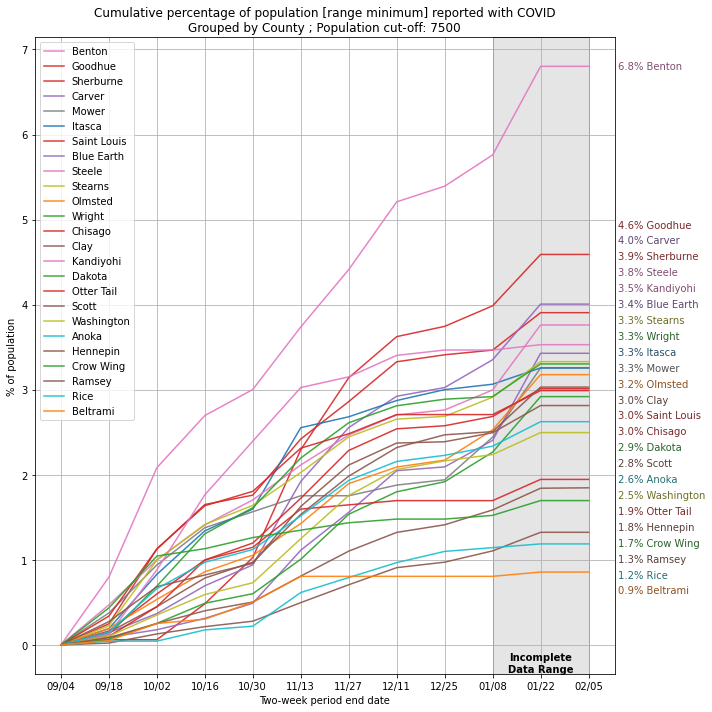

In [8]:
plot_grouped(group_by='County', min_pop=7500, plot_max=False)


You can set the search terms for County, District, or School, as well as
a minimum enrollment (min_pop) to consider. Based on reporting, there is a
range of potential values (max:min); by default plot a shaded region showing
the range; plot lines by disabling the edge you don't want with 
plot_max=False or plot_min=False

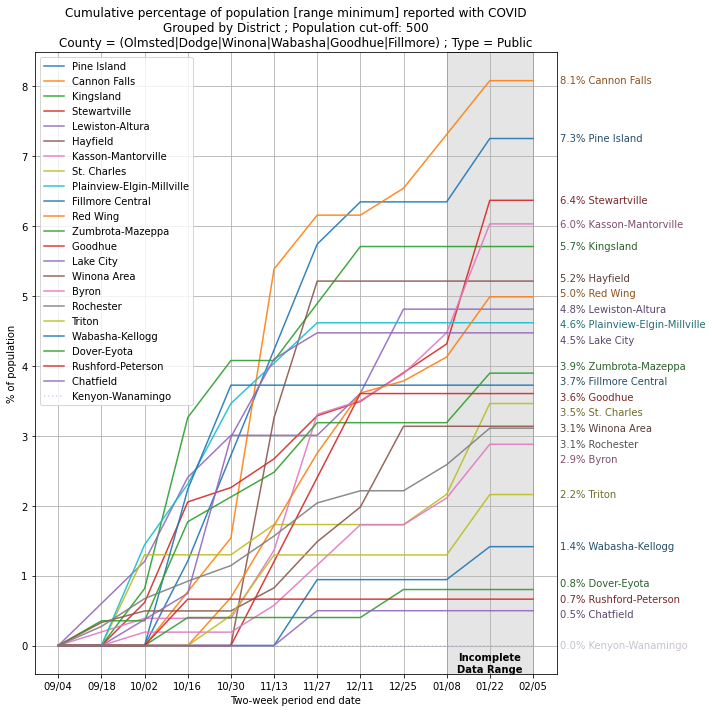

In [9]:
plot_grouped(County='(Olmsted|Dodge|Winona|Wabasha|Goodhue|Fillmore)',
             group_by='District',
             min_pop=500, plot_max=False, Type='Public')

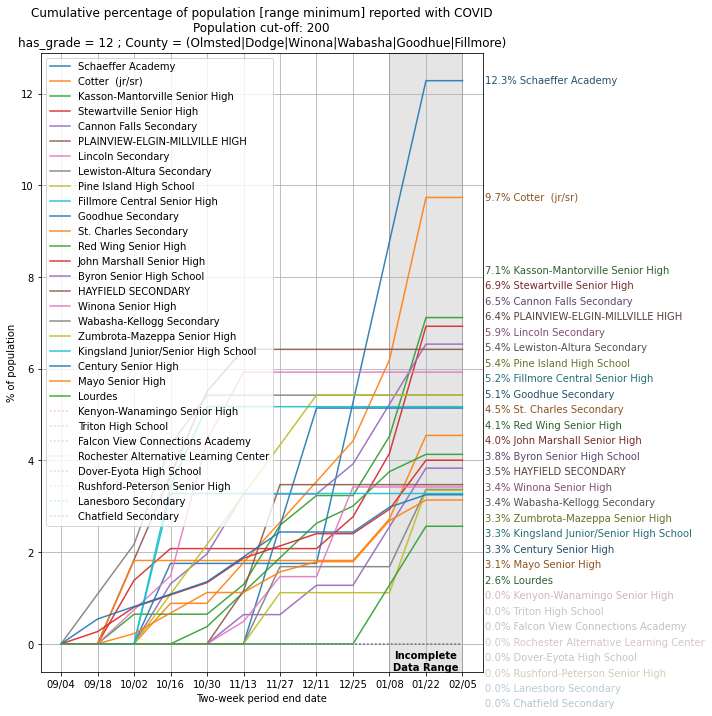

In [10]:
plot_matches(has_grade=12, County='(Olmsted|Dodge|Winona|Wabasha|Goodhue|Fillmore)',
             min_pop=200, plot_max=False)

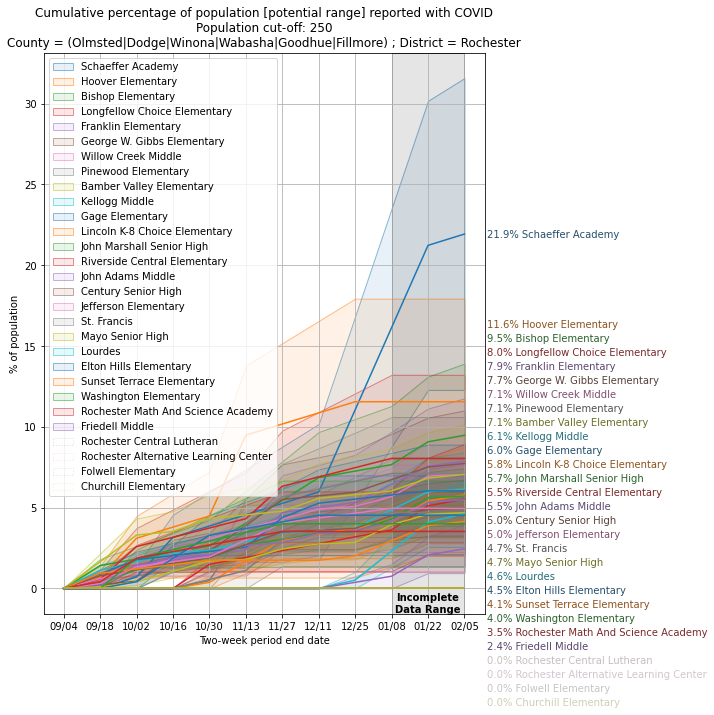

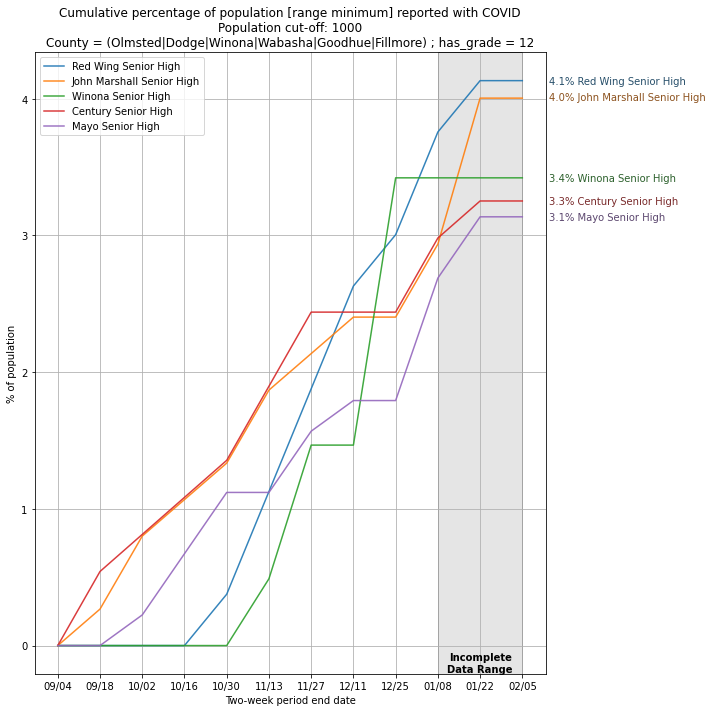

In [11]:
plot_matches(min_pop=250, County='(Olmsted|Dodge|Winona|Wabasha|Goodhue|Fillmore)', District='Rochester')
plot_matches(min_pop=1000, County='(Olmsted|Dodge|Winona|Wabasha|Goodhue|Fillmore)', has_grade=12, plot_max=False)

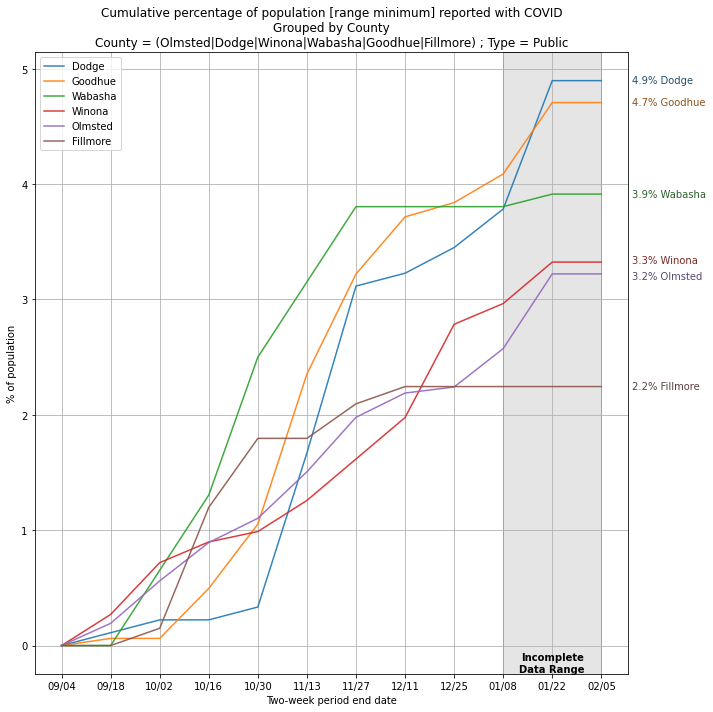

In [12]:
plot_grouped(County='(Olmsted|Dodge|Winona|Wabasha|Goodhue|Fillmore)',
            group_by='County', plot_max=False, Type='Public')

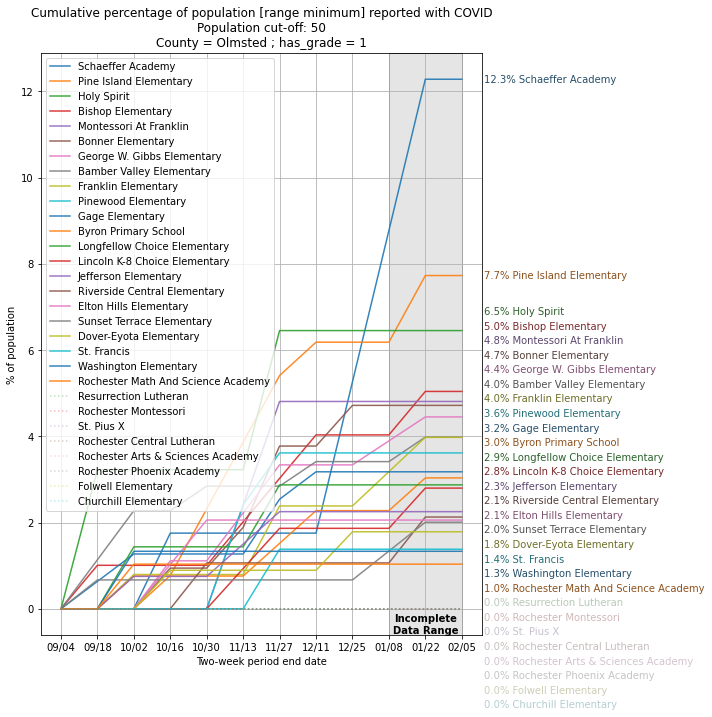

In [13]:
plot_grouped(County='Olmsted', has_grade=1, plot_max=False, min_pop=50)